# Implementation of some unsupervised machine learning methods. Among them: PCA, NMF, K-means Clustering

Adapted from: https://wiki.ml.tu-berlin.de/wiki/Main/SS18_KA

In [1]:
import numpy as np
import pylab as pl
import scipy as sp
import matplotlib.pyplot as plt
from scipy import spatial
%matplotlib inline

## PCA - Principal component Analysis;  and NMF - Non-negative matrix Factorization:

The aim is to detect trends in text data and to implement a linear kernel Principal Component Analysis (PCA), Non-negative matrix factorization (NMF) and compare the two. The text data consists of preprocessed news feeds gathered from http://beta.wunderfacts.com/ in October 2011, and you will be able to detect  a trend related to Steve Jobs death on 5th October 2011. 

The data consists of 26800 Bag-of-Words (BOW) features of news published every hour, i.e. the news are represented in a vector which contains the occurence of each word. Here we have many more dimensions (26800) than data points (645). This is why we will implement Linear Kernel PCA instead of standard PCA. 

Given data $X \in \mathbb{R}^{D \times N}$, PCA finds a decomposition of the data in $k$ orthogonal principal components that maximize the variance in the data, 

$$X = W \cdot H$$ 

with $W \in \mathbb{R}^{D \times k}$ and   $H \in \mathbb{R}^{k \times N}$. The  Pseudocode is given below. The function  ```test_assignment6``` helps you to debug your code. It plots for a 2D data set the two principal components. 

```PCA( X, k ):```
1. ```# Require: data``` $x_1, \ldots, x_N \in \mathbb R^d$, $N\ll d$ ```, number of principal components``` $k$
1. ```# Center Data```
1. $\; \; \; X = X - 1/N\sum_ix_i$
1. ```# Compute Linear Kernel```
1. $\; \; \; K = X^{\top}X$
1. ```# Compute eigenvectors corresponding to the``` $k$ ```largest eigenvalues```
1. $\; \; \; \alpha = \text{eig}(K)$
1. $\; \; \;  W = X \alpha$
1. ```# Project data onto``` $W$
1. $\; \; \; H = W^\top X$
1. ```return W, H```

In [119]:
def pca(X,ncomp=10):
    ''' Principal Component Analysis
    INPUT:  X       - DxN array of N data points with D features
            ncomp   - number of principal components to estimate 
    OUTPUT: W       - D x ncomp array of directions of maximal variance, 
                     sorted by their eigenvalues
            H       - ncomp x N array of projected data ''' 
    
    #check, if ncomp might not be larger than any of the input dimensions of X
    ncomp = min(np.hstack((X.shape, ncomp)))
    
    #center the data
    mean = np.mean(X,axis=1)[:,np.newaxis]
    X = X-mean    
    
    # compute linear kernel
    K_l = np.dot(X.T,X)
    
    # compute eigenvectors and sort them according to their eigenvalues
    w,v =np.linalg.eig(K_l)
    indizes = np.flipud(np.argsort(w))
    w,v = w[indizes], v[indizes]
        
    # compute W and H 
    W = np.dot(X,v[:,:ncomp])
    H = np.dot(W.T, X)
    
    return W,H

#Loading the data from a local file
def get_data(fname='newsdata_BOW.npz'):
    #load data
    foo = np.load(fname, encoding = 'latin1')
    #foo = np.load(fname)
    #split into dates (stamp), Bag of Words (data vectors) and words (dimensions/features)
    dates = foo['dates']
    BOW = np.array(foo['BOW_features'].tolist().todense())
    words = foo['words']
    return BOW,words,dates
    
def nmf(X,ncomp=10,its=100):
    '''Non-negative matrix factorization as in Lee and Seung http://dx.doi.org/10.1038/44565
    INPUT:  X       -  DxN array of N data points with D features
            ncomp   - number of factors to estimate
            its     - number of iterations
    OUTPUT: W       - D x ncomp array
            H       - ncomp x N array ''' 
    ncomp = min(np.hstack((X.shape, 10)))
    X = X + 1e-19
    # initialize randomly
    W = sp.random.rand(X.shape[0],ncomp)
    H = sp.random.rand(X.shape[1],ncomp).T
    # update for its iterations
    for it in sp.arange(its):
        H = H * (W.T.dot(X)/(W.T.dot(W.dot(H))))
        W = W * (X.dot(H.T)/(W.dot(H.dot(H.T))))
    return W,H
    
def plot_trends(ntopics=8,method=nmf,topwhat=10):
    #load data
    BOW,words,dates = get_data()
    topics,trends = method(BOW,ntopics)
    for itopic in range(ntopics):
        pl.figure(figsize=(8,6))
        pl.plot(trends[itopic,:].T)
        ranks = (-abs(topics[:,itopic])).argsort()
        thislabel = words[ranks[:topwhat]]
        pl.legend([thislabel])
        days = sp.arange(0,BOW.shape[-1],24*7)
        pl.xticks(days,dates[days],rotation=20)

def test_pca():
    ##Example 1
    X = sp.array([[0, 1], [0, 1]])
    W, H = pca(X, ncomp = 1)
    assert(sp.all(W / W[0] == [[1], [1]])) 
    print('2 datapoint test passed')
    
    ##Example 2
    #generate 2D data
    N =100
    cov = sp.array([[10, 4], [4, 5]])
    X = sp.random.multivariate_normal([0, -20], cov, N).T
    #do pca 
    W, H = pca(X)
    #plot result
    pl.figure()
    pc0 = 10*W[:,0] / np.linalg.norm(W[:,0])
    pc1 = 10*W[:,1] / np.linalg.norm(W[:,1])
    pl.plot([-pc0[0], pc0[0]], [-pc0[1]-20, pc0[1]-20], '-k', label='1st PC')
    pl.hold(True)
    pl.plot([-pc1[0], pc1[0]], [-pc1[1]-20, pc1[1]-20], '-.r', label='2nd PC')
    pl.plot(X[0,:], X[1,:], '+', color='k')
    pl.axis('equal')
    pl.legend(loc=1)
    pl.title('linear kernel PCA')

    
def test_nmf():
    #generate 2D data
    N =100
    cov = sp.array([[10, 4], [4, 5]])
    X = sp.random.multivariate_normal([0, -20], cov, N).T
    #do pca 
    W, H = nmf(X)
    #plot result
    pl.figure()
    pc0 = 10*W[:,0] / np.linalg.norm(W[:,0])
    pc1 = 10*W[:,1] / np.linalg.norm(W[:,1])
    pl.plot([-pc0[0], pc0[0]], [-pc0[1]-20, pc0[1]-20], '-k', label='1st feature')
    pl.hold(True)
    pl.plot([-pc1[0], pc1[0]], [-pc1[1]-20, pc1[1]-20], '-.r', label='2nd feature')
    pl.plot(X[0,:], X[1,:], '+', color='k')
    pl.axis('equal')
    pl.legend(loc=1)
    pl.title('NMF')
    

### Testing the PCA-implementation. The plot shows the first 2 principal components of a 2-dimensional toy dataset.

2 datapoint test passed


/home/peter/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/peter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/home/peter/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/home/peter/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


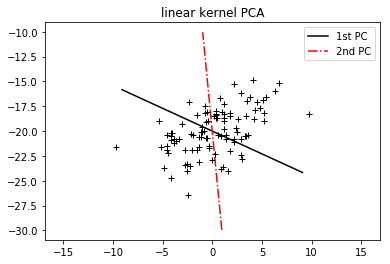

In [120]:
test_pca()

### Testing the NMF-implementation. The plot shows the first 2 identified feature vectors of a 2-dimensional toy dataset.

/home/peter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:111: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/home/peter/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/home/peter/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


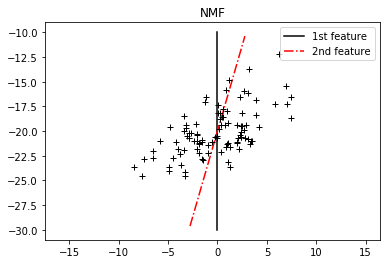

In [122]:
test_nmf()

### Now, we try to use the two implemented methods (linear kernel PCA and NMF) to detect trends in the BOW news data. As you can see, 

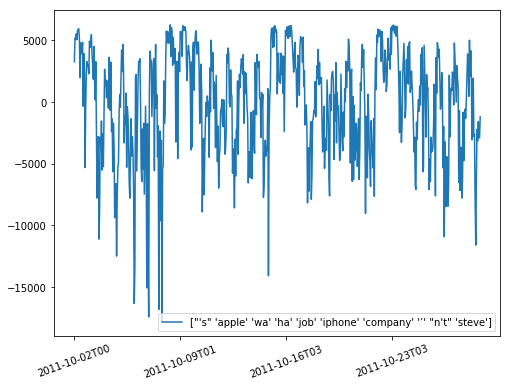

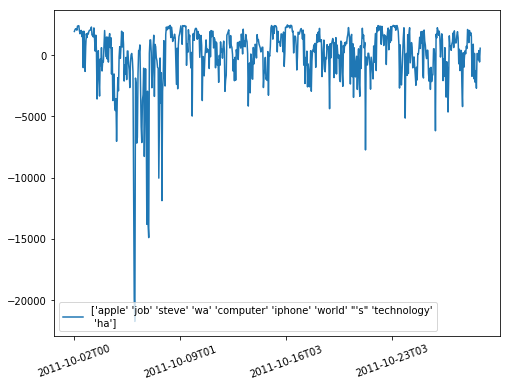

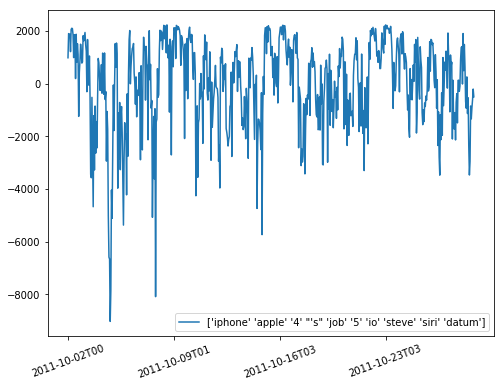

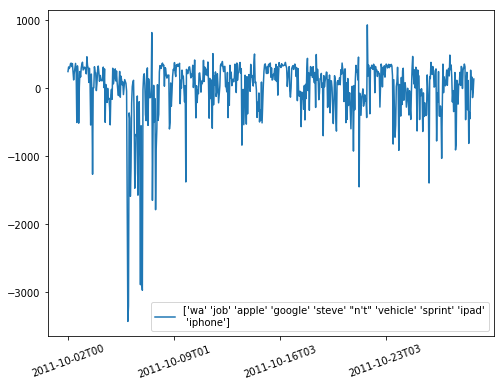

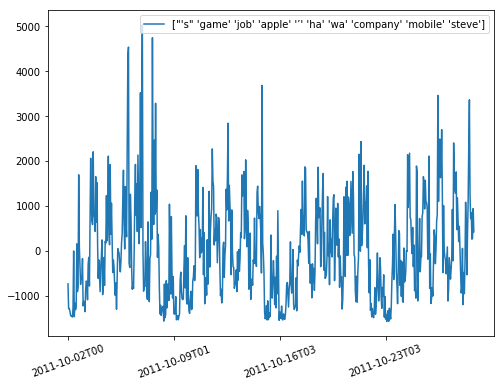

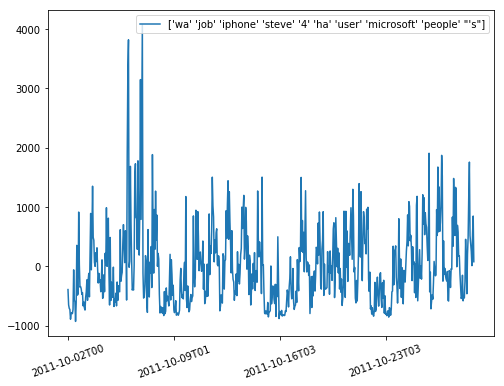

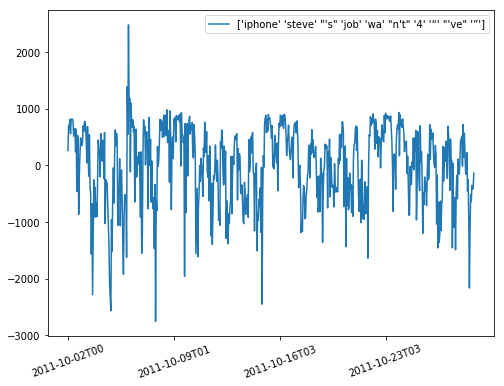

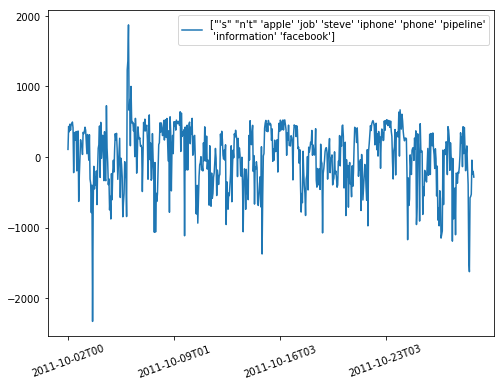

In [114]:
plot_trends(method=pca)

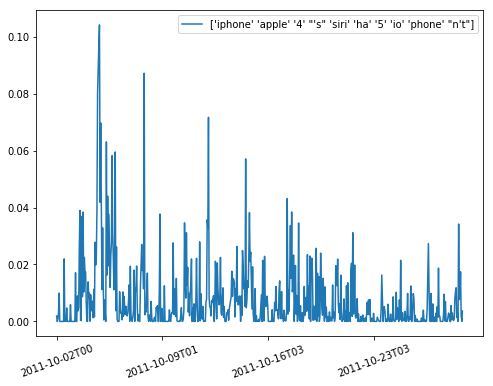

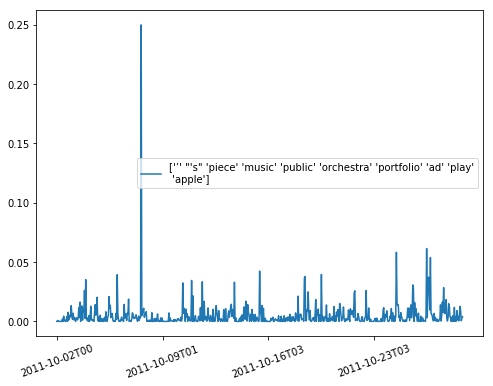

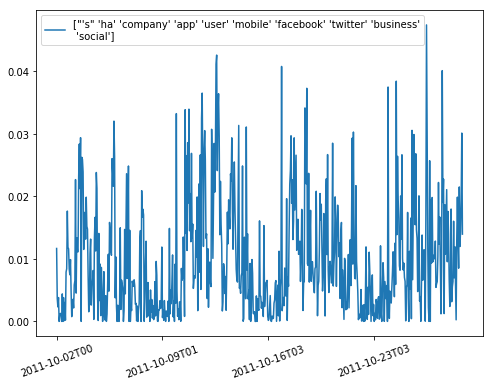

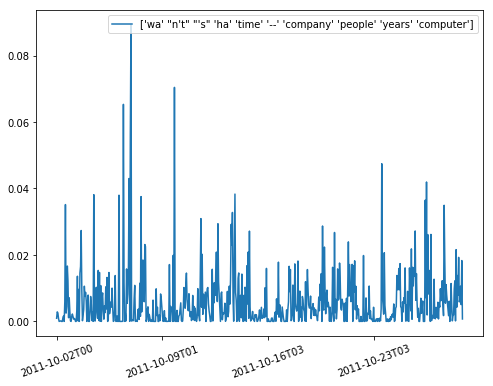

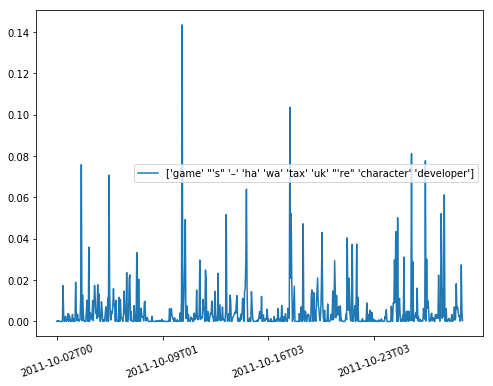

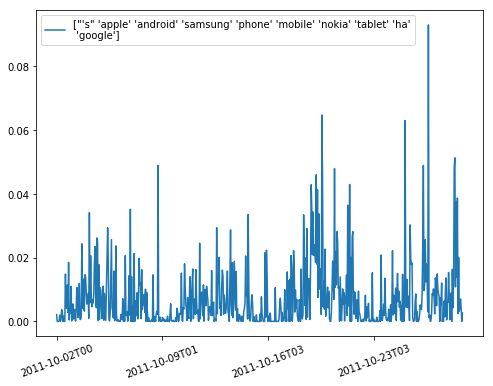

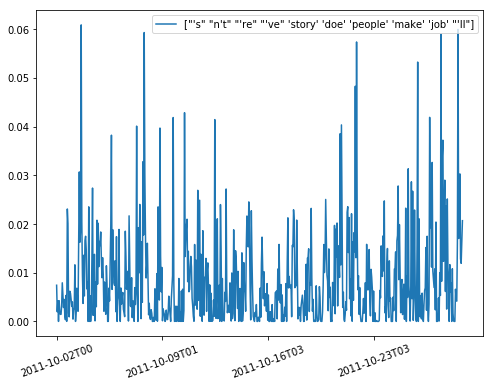

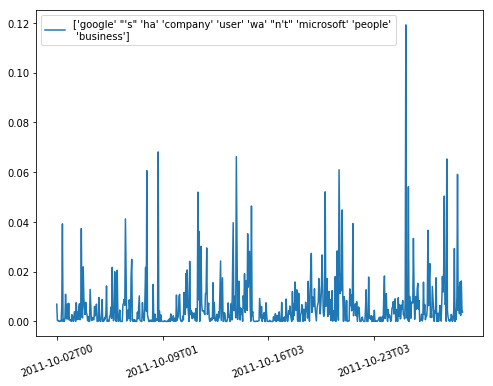

In [115]:
plot_trends(method=nmf)

## K-Means Clustering

The $K$-Means Clustering algorithm finds cluster centers $\mu_1 \ldots \mu_K$ such that the distance of the data points to their respective cluster center are minimized. This is done by re-iterating two steps:
1. Assign each data point $x_n$ to their closest cluster $\mu_k$ (for all $n = 1 \ldots N$)
1. Update each cluster center $\mu_k$ to the mean of the members in that cluster $k$ (for all $k = 1 \ldots K$)

**A)** Initialize the centroids. To do so calculate the mean of the whole data set and add some standard normal distributed noise to it, i.e. for all $k = 1 \ldots K$

$$\mu_k = \bar{x} + \epsilon_k$$

where $\bar{x}, \epsilon_k \in \mathbb{R}^D$ and $\bar{x} = \frac{1}{N} \sum_{n=1}^{N} \mathbf{x_n}$ and $\epsilon_k \sim \mathcal{N}(\mathbf{0}, I)$ 

**B)** For step 1 of the algorithm, we need the distance between each data point $x_n$ and each centroid $\mu_k$. Complete the function ```distmat``` that calculates a matrix $Dist \in \mathbb{R}^{N,K}$ such that 

$$Dist_{n,k} = || x_n - \mu_k ||_2^2 $$

We can calculate the matrix $Dist$ without the use of for-loops by using following formula:

$$Dist = A - 2 B + C  $$

where $A_{n,k} = x_n^T x_n \; \; , \; \; B_{n,k} = x_n^T \mu_k \;$ and $\; C_{n,k} = \mu_k^T \mu_k$

**C)** Assign each data point to its closest centroid. To do so, construct a matrix $Closest \in \mathbb{R}^{N,K}$ such that 

$$Closest_{n,k} = \begin{cases} 1 & \; \; \tt{if} \; \; \mu_k \text{ is the closest centroid to } x_k \\ 0 & \; \; \text{otherwise} \end{cases}$$

i.e. each row of $Closest$ holds only one non-zero element.

**D)** Update each cluster center to the mean of the members in that cluster, i.e. for all $k = 1 \ldots K$ 

$$\mu_k = \frac{1}{|{\mathcal{X_k}}|} \sum_{x \in \mathcal{X_k}} x$$ 

$$\mathcal{X_k} = \{ x_n \in X \; | \text{ the closest centroid to } x_n \text{ is } \mu_k \}$$

In [2]:
def kmeans(X, K, max_iter=50, eta=0.05):
    """ k-Means Clustering
    INPUT:  X            - DxN array of N data points with D features
            K            - number of clusters
            max_iter     - maximum number of iterations
            eta          - small threshold for convergence criterion
    OUTPUT: centroids    - DxK array of K centroids with D features
            closest      - NxK array that indicates for each of the N data points
                           in X the closest centroid after convergence.
                           Each row in closest only holds one non-zero entry. 
                           closest[n,k] == 1 <=> 
                           centroids[:,k] is closest to data point X[:,n]
    """
    #initialize distance- and closest-matrix
    D,N = np.shape(X)
    dist = np.zeros([N,K])
    closest = np.zeros([N,K])
    # initialize the centroids (close to the mean of X)
    X_mean = np.mean(X,axis=1)
    #covariance matrix for the multivariate gaussian distribution
    cov = [[0.1, 0],[0, 0.1]]
    centroids = (sp.random.multivariate_normal(X_mean, cov, K)).T
        
    cur_iter = 0
    while cur_iter < max_iter:
        plot_cluster(X, centroids, closest)
        cur_iter += 1
        old_centroids = centroids.copy()
        # calculate the distance between each data point and each centroid
        dist = distmat(X,centroids)
        # get for each data point in X it's closest centroid
        
        closest[:,indizes]=1
        # update the estimation of the centroids
        # ... your code here ...
        
        if np.linalg.norm(old_centroids - centroids) < eta:
            print('Converged after ' + str(cur_iter) + ' iterations.')
            break;
            
    return centroids, closest

def distmat(X, Y):
    """ Distance Matrix
    INPUT:      X           - DxN array of N data points with D features
                Y           - DxM array of M data points with D features
    OUTPUT:     distmat     - NxM array s.t. D[n,m] = || x_n - y_m ||^2
    Hint: np.tile might be helpful
    """
    D_x,N = np.shape(X)
    D_y,M = np.shape(Y)
    assert D_x == D_y
    # calculate the distance matrix
    distmat = sp.spatial.distance.cdist(X.T,Y.T, metric='euclidean')
    
    '''
    #or, alternatively:
    A = np.dot(X.T,X)
    B = np.dot(X.T,Y)
    C = np.dot(Y.T,Y)
    distmat = A - 2*B +c
    '''
    
    return distmat
    

def test_kmeans():
    #generate 2D data
    N =500
    cov = np.array([[1, 0], [0, 0.5]])
    # generate for each of the three clusters N data points
    x1 = np.random.multivariate_normal([-2, 2], cov, N) 
    x2 = np.random.multivariate_normal([2, 2], cov, N) 
    x3 = np.random.multivariate_normal([-2, -2], cov, N)
    X = np.vstack((x1, x2, x3)).transpose()
    
    # run kmeans and plot the result
    centroids, closest = kmeans(X, 3)
    plot_cluster(X, centroids, closest)

    
def plot_cluster(X, centroids, closest):
    K = np.shape(centroids)[1]
    plt.figure()
    plt.scatter(X[0], X[1])
    if (closest != np.zeros(np.shape(closest))).any():
        for k in xrange(K):
            # get for each centroid the assigned data points
            Xk = X[:, closest[:,k]]
            # plot each cluster in a different color
            plt.scatter(Xk[0], Xk[1])
    # plot each centroid (should be center of cloud)
    plt.scatter(centroids[0], centroids[1])


Now we test our K-means algorithm.

Converged after 1 iterations.


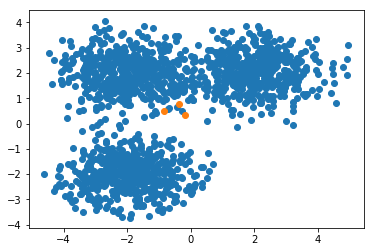

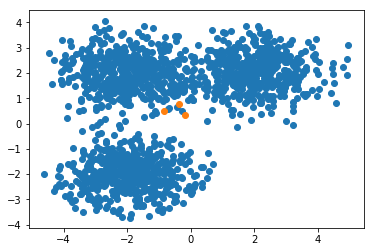

In [3]:
test_kmeans()

Converged after 1 iterations.
(2, 3)
[[-0.60636846 -0.63231165 -0.24458938]
 [ 0.33610653  0.52341264  0.5939177 ]]
(1500, 3)
(2, 1500)


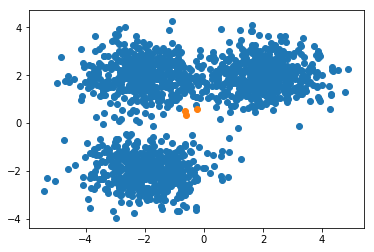

In [22]:
N =500
cov = np.array([[1, 0], [0, 0.5]])
# generate for each of the three clusters N data points
x1 = np.random.multivariate_normal([-2, 2], cov, N) 
x2 = np.random.multivariate_normal([2, 2], cov, N) 
x3 = np.random.multivariate_normal([-2, -2], cov, N)
X = np.vstack((x1, x2, x3)).transpose()
    
# run kmeans and plot the result
centroids, closest = kmeans(X, 3)

print(centroids.shape)
print(centroids)
print(closest.shape)
print(X.shape)

In [27]:
X = np.random.rand(5,4)
print(X)
print(X.shape)
print()

max = np.argmax(X,axis=1)

min = np.unravel_index(np.argmax(X, axis=1), X.shape)

print(max)
print(min)

print()
print(min[0])
print(min[1])


[[0.52013994 0.31524948 0.39995597 0.16583339]
 [0.82964173 0.14153237 0.48624439 0.96520625]
 [0.82865569 0.49285067 0.02312828 0.41580193]
 [0.03740099 0.68159721 0.99473341 0.81883059]
 [0.33696142 0.7879847  0.62789994 0.72949179]]
(5, 4)

[0 3 0 2 1]
(array([0, 0, 0, 0, 0]), array([0, 3, 0, 2, 1]))

[0 0 0 0 0]
[0 3 0 2 1]
